## Open-ended Task

Our main research question is: How different meanings of stimuli affect the brain region measured during fMRI.


In order to investigate the question in depth, in this project we decided to perform several analyzes for each specific research question

The research question are:
1. How the positive or negative context of a sentence or paragraph affects the fMRI measurements and the brain cortical hippocampus.
2. Are there diffrent areas of the brain that are activated in every context or stimulation type (eg: happy ,mad ,etc).

How the positive or negative context of a sentence or paragraph affects the fMRI measurements

In order to analyze the research question we need to obtain words or sentences labeled "positive" or "negative" = Sentiment Analysis
we used "Getting Started with Sentiment Analysis using Python" by HaggingFace

#### genreal prep (for both parts )

##### install transformer (IMPORTANT )

In [1]:
!pip install -q transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.3 MB/s eta 0:00:00




##### loading data

##### load data

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

In [2]:
# loading the pickles files
import pickle
import copy
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in your Google Drive
file_path2 = '/content/drive/MyDrive/Structured Task (sentence decoding)/EXP2.pkl'
file_path3 = '/content/drive/MyDrive/Structured Task (sentence decoding)/EXP3.pkl'
# Open and load the file
with open(file_path2, 'rb') as f:
    exp2 = pickle.load(f)
with open(file_path3, 'rb') as f:
    exp3 = pickle.load(f)

Mounted at /content/drive


In [3]:
# getting the vectors, concepts (sentences) and the data
#data2
import numpy as np
with open('/content/drive/MyDrive/Structured Task (sentence decoding)/vectors_384sentences.GV42B300.average.txt', 'r') as file:
    content = file.readlines()
vectors2 = np.array([row.split() for row in content])

concepts2 = exp2['keySentences']
data2 = exp2["Fmridata"]

#data3
with open('/content/drive/MyDrive/Structured Task (sentence decoding)/vectors_243sentences.GV42B300.average.txt', 'r') as file:
    content = file.readlines()
vectors3 = np.array([row.split() for row in content])

concepts3 = exp3['keySentences']
data3 = exp3["Fmridata"]

In [4]:
# cobining both experiments to get larger data
concepts_c = []
for i in range(len(concepts2)):
    concepts_c.append(concepts2[i][0][0])
for i in range(len(concepts3)):
    concepts_c.append(concepts3[i][0][0])

vectors_c = np.append(vectors2, vectors3, axis =0)
data_c = np.append(data2, data3, axis =0)

In [70]:
## make sure to load file before running
loaded_array = np.load('active_voxels_from_unstruct (1).npy')
active_voxels= data_c[:,loaded_array[0]]
active_voxels.shape

(627, 512)

##### loading decoder model

In [6]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

--2023-07-02 12:07:19--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 142.250.99.138, 142.250.99.113, 142.250.99.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4jjkldneljh963f7te163r3vtudcepmf/1688299575000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=2bceab88-4ef3-483d-927d-2040984a6144 [following]
--2023-07-02 12:07:20--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4jjkldneljh963f7te163r3vtudcepmf/1688299575000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=2bceab88-4ef3-483d-927d-2040984a6144
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 74.125.199.132, 

### First research question - Sentiment Analysis

#####load model

In [7]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)


In [8]:

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


#### labeling data

In [9]:
#this function return the lable according to the huggingface algorithem
def get_lable(text):
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  sscores = softmax(scores)
  ranking = np.argsort(sscores)
  ranking = ranking[::-1]
  l = labels[ranking[0]]
  return l ,sscores

In [10]:
concepts_cop = []
vectors_cop = []
data_cop = []
data_part2 = np.zeros((157,len(data2[0])))
labels_part2 = np.zeros(157)
scores_c=[]

In [11]:
#getting the lables for each text and emove neutral as it is not relevent in this experiment
vectors_dict = {}
concepts_dict = {}
x = 0
for i in range(len(concepts_c)):
  vec = vectors_c[i]
  con = concepts_c[i]
  d = data_c[i]
  l ,scores= get_lable(con)
  scores_c.append(scores)
  if l != "neutral":
    data_cop.append(d)
    vectors_cop.append(vec)
    concepts_cop.append(con)
    string_vec = np.array2string(vec)
    vectors_dict[string_vec] = l
    concepts_dict[con] = {"true_lable": l, "predict": None}
    data_part2[x] = d
    labels_part2[x] = (1 if l == "positive" else 0)
    x+=1


#### quickly test if there is a signifact diffrenace between the two catagories

In [12]:
# we define strong conaction being 3 times more actice than other voxels
alpha =3

In [13]:
scores_c =np.array(scores_c)
s0 = scores_c[:,0]
s2 = scores_c[:,2]

In [69]:
allsum = np.sum(data_c,axis=0)
allcount=len(data_c)
mask = np.array(s0) > 0.5
negsum = np.sum(data_c[mask],axis=0)
negcount = np.count_nonzero(mask)
mask = np.array(s2) > 0.5
possum = np.sum(data_c[mask],axis=0)
poscount = np.count_nonzero(mask)
diffneg = negsum/negcount - (allsum-negsum)/(allcount-negcount)
diffpos = possum/poscount - (allsum-possum)/(allcount-poscount)
mean_abs = np.mean(np.abs(allsum)) /allcount
posabove = np.where(diffpos >alpha*mean_abs )[0]
posbelow = np.where(diffpos <-alpha*mean_abs )[0]
negabove = np.where(diffneg >alpha*mean_abs )[0]
negbelow = np.where(diffneg <-alpha*mean_abs )[0]
uni_acti_voxels =np.unique( np.concatenate((posabove,posbelow,negabove,negbelow)) )
print("the amount of voxels with strong reaction to sementive stimuli :", len(uni_acti_voxels))

the amount of voxels with strong reaction to sementive stimuli : 482


##### strong areas in 3D brain graph

In [15]:
#todo # was advised to drop this graph due to brain normolzation done to data complecations

#### K-nearest nighbors , to test is catagories are similar to each other

In [16]:
from learn_decoder import *

#seems to be unsed
#data = read_matrix("imaging_data.csv", sep=",")
#vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
#concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [17]:
# we will have 13 folds each have 12 sentences we will calcaulate M each time and get the neg/pos according to the first k closest vectors
#elad 20/6/23 should be avoided ( has many pre programed numbers )
def k13_fold(data, vectors):
  # constant numbers
  NUM_K = 13
  NUM_IN_GROUP = 12
  NUM_CONCEPTS = 300
  NUM_V = 185866
  #creating empty arrays
  split_data = np.zeros((NUM_K,NUM_IN_GROUP,NUM_V))
  split_vectors = np.zeros((NUM_K,NUM_IN_GROUP,NUM_CONCEPTS))
  j = 0
  for i in range(0,156,12):
      split_data[j] = data[i:i+12]
      split_vectors[j] = vectors[i:i+12]
      j += 1
  return split_data, split_vectors

In [18]:
# function that computes rank-based accuracy score.
# it gets v, v_hat and the 156 true semantic vectors
# it calculate the ranking for this vector
from sklearn.metrics.pairwise import cosine_similarity

def calculate_lable(v, v_hat, vectors,K, vectors_dict):
  count_dict = {"positive": 0, "negative": 0}
  simularity_array = []
  for vec in vectors:
    simu = cosine_similarity([vec] , [v_hat])
    simularity_array.append([simu,vec])
    sorted_list = sorted(simularity_array, key=lambda x: x[0],reverse=True)

  K_nearest = sorted_list[:K]
  for k in range(K):
    vec = K_nearest[k][1]
    string_vec = np.array2string(vec)
    l = vectors_dict[string_vec]
    count_dict[l] += 1
  sum = count_dict["positive"] + count_dict["negative"]
  if (count_dict["positive"] / sum ) > 0.5:
    return "positive"
  else:
    return "negative"


In [19]:
# function to go over the 18 folds and do the calculation for the graphs
import copy

def get_prdiction(data,vectors,concepts,vectors_dict,concepts_dict,num_nei):
  kf = KFold(n_splits=13)
  if not isinstance(data, np.ndarray):
    data= np.array(data)
  if not isinstance(vectors, np.ndarray):
    vectors= np.array(vectors)
  if not isinstance(concepts, np.ndarray):
    concepts= np.array(concepts)
  #split_data, split_vectors = k13_fold(data,vectors)

  score_for_concept = {}
  score_for_fold = {}
  for train_index, test_index in kf.split(data):
    train_set_data, test_set_data = data[train_index], data[test_index]
    train_set_vectors, test_set_vectors = vectors[train_index] ,vectors[test_index]
    train_set_labels , test_set_labels = concepts[train_index] ,concepts[test_index]

    #caculate M:
    M = learn_decoder(train_set_data,train_set_vectors)

    #go over the test set and compute the lable
    for j in range(len(test_index)):
      temp_v = test_set_data[j]
      lable = test_set_labels[j]
      v_hat = np.dot(temp_v, M)
      v = test_set_vectors[j]
      pred_lab =  calculate_lable(v, v_hat, vectors, num_nei, vectors_dict)
      concepts_dict[lable]["predict"] = pred_lab

  return concepts_dict



##### run K-nearest model

In [20]:
#use pca to remove noise:
import numpy as np
from sklearn.decomposition import PCA
number_to_represnt_the_brain_and_life_as_a_whole =100
pca = PCA(n_components=number_to_represnt_the_brain_and_life_as_a_whole)
pcaData = pca.fit_transform(data_cop)

#test pca
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Calculate variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Calculate cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

print("###### total cumulative variance ", cumulative_variance_explained[-1])

###### total cumulative variance  0.9411268958585977


In [23]:
#pred_dict = get_prdiction(data_cop,vectors_cop,concepts_cop, vectors_dict,concepts_dict,5)
pred_dict = get_prdiction(pcaData,vectors_cop,concepts_cop, vectors_dict,concepts_dict,19)

In [24]:
# getting the accuracy score for each semantic
label_counts = {
    'positive': {'total': 0, 'correct': 0},
    'negative': {'total': 0, 'correct': 0},
}
acc_dict = {'positive': 0,
    'negative': 0}

for key in pred_dict.keys():
    true_label = pred_dict[key]['true_lable']
    predicted_label = pred_dict[key]['predict']

    label_counts[true_label]['total'] += 1

    if true_label == predicted_label:
        label_counts[true_label]['correct'] += 1

for label, counts in label_counts.items():
    accuracy = counts['correct'] / counts['total'] * 100 if counts['total'] > 0 else 0
    acc_dict[label] = accuracy
print(acc_dict)
    # print(f"Label: {label}, Accuracy: {accuracy:.2f}% k is: {5}",)

{'positive': 41.07142857142857, 'negative': 83.16831683168317}


##### results

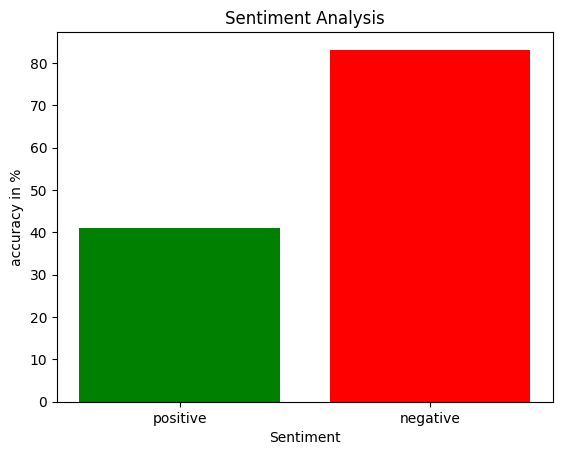

In [25]:
import matplotlib.pyplot as plt

labels = list(acc_dict.keys())
values = list(acc_dict.values())
colors = ['green', 'red']
plt.bar(labels, values, color=colors)
plt.xlabel("Sentiment")
plt.ylabel("accuracy in %")
plt.title("Sentiment Analysis")

plt.show()


**conclution for first analysis:**
we got 87.1% for prediction of "negative" and 44.6% for "positive"


#### testing threshhold for strong sitemint using logistic regreastion

##### pre for labeling

In [26]:
def TrueFalseTest(y_test, y_pred):
  tp_fp_fn_tn =[0,0,0,0]
  for test,pred in zip(y_test, y_pred ):
    if test:
      if pred:
        tp_fp_fn_tn[0]+=1 #true postive
      else:
        tp_fp_fn_tn[2]+=1
    else:
      if pred:
        tp_fp_fn_tn[1]+=1 # false posite
      else:
        tp_fp_fn_tn[3]+=1
  if tp_fp_fn_tn[0]==0:
    return 0
  return tp_fp_fn_tn[0]/(tp_fp_fn_tn[0]+0.2*tp_fp_fn_tn[1] +0.8*tp_fp_fn_tn[2])
  #print("TP:",tp_fp_fn_tn[0],"FP:",tp_fp_fn_tn[2],"FN:",tp_fp_fn_tn[1],"TN:",tp_fp_fn_tn[3] )

##### classification test based on streangth

In [27]:
sc=np.array(scores_c).T
sc.shape

(3, 627)

In [30]:
def  classification_strong_test(is_label):
  data_type = np.array(active_voxels)
  data_copy=data_type
  over_sample_ratio= 0.1
  accur_per_fold =[]
  strangth =[]
  tprr=[]
  fprr=[]
  for  i in range(1,10):
    strong=0.1 *i
    strong_positve = is_label >strong

    num_strong =np.count_nonzero(strong_positve)
    num_waek =len(is_label)-num_strong
    #### over smaple
    cur_r = num_strong/ len(is_label)
    if not cur_r:
      continue
    strangth.append("At "+str(round(strong,2)))
    over_by = int(np.floor(0.9+(over_sample_ratio-cur_r)/cur_r))
    over_by=0
    if over_by:
      to_tile=data_copy[strong_positve]
      tiled_arr = np.repeat(to_tile,over_by,axis=0)
      data_type = np.concatenate((data_copy,tiled_arr))
      array = np.ones(len(data_type)-len(strong_positve), dtype=bool)
      strong_positve = np.concatenate((strong_positve,array))
    ###
    #X, y = np.array(data_c) , np.array(strong_positve)
    X , y = np.array(data_type) , np.array(strong_positve)
    kf = KFold(n_splits=7)
    tempA=[]
    tempF=[]
    tempWP =[]
    TP=0
    FP=0
    TN=0
    FN=0
    for train_index, test_index in kf.split(y):
      X_train, X_test=X[train_index], X[test_index]
      y_train, y_test =y[train_index], y[test_index]
      model = LogisticRegression(max_iter=10000) #12 sec
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      tempWP.append((len(s2)-np.count_nonzero(y_pred))/len(is_label))
      tempA.append( accuracy_score(y_test, y_pred))
      tempF.append(TrueFalseTest(y_test, y_pred))
      TP+=np.count_nonzero(np.logical_and(y_test, y_pred))
      FP+=np.count_nonzero(np.logical_and((y_test==False), y_pred))
      FN+=np.count_nonzero(np.logical_and(y_test, (y_pred==False)))
      TN+=np.count_nonzero(np.logical_and((y_test==False), (y_pred==False)))
    tprr.append(TP/(TP+FN))
    fprr.append(FP/(FP+TN))
    accur_per_fold.append(tempA)
  import matplotlib.pyplot as plt

  # Calculate average and variation for each category
  averagesA = np.mean(accur_per_fold, axis=1)
  variationsA = np.std(accur_per_fold, axis=1)


  # Plotting the graph
  fig, ax = plt.subplots()
  ax.boxplot(np.array(accur_per_fold).T, labels=strangth)
  ax.set_title('Accuracy Scores by strong sementive threashold')
  ax.set_xlabel('threashold')
  ax.set_ylabel('postive Accuracy Score')

  # Add average and variation labels
  for i in range(len(strangth)):
      ax.text(i + 1, averagesA[i], f'Avg: {averagesA[i]:.2f}', ha='center', va='bottom')

  plt.show()

  # Plot the ROC curve
  plt.figure()
  plt.plot(fprr, tprr, color='darkorange', lw=2)#,label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [33]:
to_test =[s0,s2]
for i in to_test:
  classification_strong_test(i)

IndexError: ignored

In [34]:
labels[::2]

['positive']

#### fourth analysis - using the feedforward neural networks for deep learned connecion






In [35]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split


In [36]:
print(data_part2.shape[1])
pcaData.shape

185866


(157, 100)

In [37]:
samples = []
for i in range(0,10):
  # Define the model architecture
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(pcaData.shape[1],)),
      tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Split the data into training and testing sets
  # train_data = data_part2[:140]
  # train_labels = labels_part2[:140]
  # test_data = data_part2[140:]
  # test_labels = labels_part2[140:]
  train_data, test_data, train_labels, test_labels = train_test_split(pcaData, labels_part2, test_size=0.1)
  # Train the model
  model.fit(train_data, train_labels, epochs=10, batch_size=32)

  # Evaluate the model on the test set
  loss, accuracy = model.evaluate(test_data, test_labels)
  print('Test Loss:', loss)
  print('Test Accuracy:', accuracy)
  samples.append(accuracy)
samples


Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 4.2276 - accuracy: 0.6454
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 3.9235 - accuracy: 0.6454
Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 3.6518 - accuracy: 0.6454
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 3.3834 - accuracy: 0.6454
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 3.1488 - accuracy: 0.6454
Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 2.9168 - accuracy: 0.6454
Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 2.7138 - accuracy: 0.6454
Epoch 8/10
5/5 [==============================] - 0s 3ms/step - loss: 2.5214 - accuracy: 0.6454
Epoch 9/10
5/5 [==============================] - 0s 3ms/step - loss: 2.3464 - accuracy: 0.6454
Epoch 10/10
1/1 [==============================] - 0s 138ms/step - loss: 2.1042 - accuracy: 0.6250
Test Loss: 2.104235887527466
Test Acc

1/1 [==============================] - 0s 119ms/step - loss: 2.1776 - accuracy: 0.7500
Test Loss: 2.1776015758514404
Test Accuracy: 0.75
Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 4.4262 - accuracy: 0.3546
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 4.0385 - accuracy: 0.6383
Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 3.7871 - accuracy: 0.6383
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 3.5327 - accuracy: 0.6383
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 3.2922 - accuracy: 0.6383
Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.0753 - accuracy: 0.6383
Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 2.8711 - accuracy: 0.6383
Epoch 8/10
5/5 [==============================] - 0s 3ms/step - loss: 2.6796 - accuracy: 0.6383
Epoch 9/10
5/5 [==============================] - 0s 3ms/step - loss: 2.5053 - accuracy: 0.6383

1/1 [==============================] - 0s 122ms/step - loss: 2.2211 - accuracy: 0.6875
Test Loss: 2.2211050987243652
Test Accuracy: 0.6875
Epoch 1/10
5/5 [==============================] - 1s 5ms/step - loss: 4.4041 - accuracy: 0.3901
Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 3.9831 - accuracy: 0.6738
Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 3.7479 - accuracy: 0.6738
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 3.4910 - accuracy: 0.6738
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 3.2397 - accuracy: 0.6738
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 3.0155 - accuracy: 0.6738
Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 2.8096 - accuracy: 0.6738
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 2.6142 - accuracy: 0.6738
Epoch 9/10
5/5 [==============================] - 0s 4ms/step - loss: 2.4377 - accuracy: 0.67

[0.625, 0.6875, 0.8125, 0.625, 0.75, 0.6875, 0.375, 0.6875, 0.8125, 0.5625]

In [38]:
print("the avarage accuracy is:" ,sum(samples)/ len(samples))

the avarage accuracy is: 0.6625


### Second research question - emotion Analysis

####loading model

In [39]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='emotion'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


In [40]:
labels

['anger', 'joy', 'optimism', 'sadness']

In [41]:

def test_model(text):
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)[0][0].detach().numpy()
  print("raw values: ",output)
  print("soft values", softmax(output))
test_model("those 'people' toke every thing , i must hurt them")
test_model("the summer break was fun, i spent my time well")
test_model("with every miss step i learn and improve to have a better future ")
test_model("the hardest part with grief is knowing you have to move foward alone")

raw values:  [ 3.1012287  -1.7754937  -0.22440125 -0.26977053]
soft values [0.92770654 0.00707094 0.03335092 0.03187162]
raw values:  [-1.845604    2.832486   -0.35760143 -1.1620624 ]
soft values [0.00869765 0.9355579  0.03851531 0.01722901]
raw values:  [-1.1458387 -0.237674   2.795863  -0.7364739]
soft values [0.01770168 0.04389606 0.91174597 0.02665628]
raw values:  [-1.2845714 -1.5092329 -1.0403293  3.6969202]
soft values [0.00672192 0.00536938 0.00858157 0.97932714]


#### labeling data

In [42]:
#this function return the lable according to the huggingface algorithem
def get_lable(text):
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  sscores = softmax(scores)
  ranking = np.argsort(sscores)
  ranking = ranking[::-1]
  l = labels[ranking[0]]
  return l ,sscores

In [43]:
data_part2 = np.zeros((627,len(data2[0])))
labels_part2 = []
concepts_cop = []
vectors_cop = []
data_cop = []

In [44]:
vectors_dict = {}
concepts_dict = {}
scores_c =[]
for i in range(len(concepts_c)):
  vec = vectors_c[i]
  con = concepts_c[i]
  d = data_c[i]
  l ,score = get_lable(con)
  scores_c.append(score)
  # data_c = np.delete(data_c, np.where(np.isin(data_c, items_to_remove)))
  # data_c = np.delete(data_c, i)
  # vectors_c = np.delete(vectors_c, i)
  # del concepts_c[i]
  data_cop.append(d)
  vectors_cop.append(vec)
  concepts_cop.append(con)
  string_vec = np.array2string(vec)
  vectors_dict[string_vec] = l
  concepts_dict[con] = {"true_lable": l, "prediction": None}
  data_part2[i] = d
  labels_part2.append(l)

#### quickly test if there is a signifact diffence between the catagories

In [45]:
alpha=3
sc=np.array(scores_c).T
allsum = np.sum(data_c,axis=0)
allcount=len(data_c)
mean_abs = np.mean(np.abs(allsum)) /allcount
to_con=[]
for i in range(4):
  mask =  sc[i]> 0.5
  nsum = np.sum(data_c[mask],axis=0)
  ncount = np.count_nonzero(mask)
  diffn = nsum/ncount - (allsum-nsum)/(allcount-ncount)
  to_con.append(np.where(diffn >alpha*mean_abs )[0])
  to_con.append(np.where(diffn <-alpha*mean_abs )[0])
active_voxels =np.unique( np.concatenate(to_con) )
print("the amount of voxels with strong reaction to sementive stimuli :", len(active_voxels))

the amount of voxels with strong reaction to sementive stimuli : 1409


#### k-nearest model

In [46]:
# we will have 19 folds each have 33 sentences we will calcaulate M each time and get the neg/pos according to the first k closest vectors
def k19_fold(data, vectors):
  # constant numbers
  NUM_K = 19
  NUM_IN_GROUP = 33
  NUM_CONCEPTS = 300
  NUM_V = 185866
  #creating empty arrays
  split_data = np.zeros((NUM_K,NUM_IN_GROUP,NUM_V))
  split_vectors = np.zeros((NUM_K,NUM_IN_GROUP,NUM_CONCEPTS))
  j = 0
  for i in range(0,627,33):
      split_data[j] = data[i:i+33]
      split_vectors[j] = vectors[i:i+33]
      j += 1
  return split_data, split_vectors

In [47]:
# function that computes rank-based accuracy score.
# it gets v, v_hat and the 156 true semantic vectors
# it calculate the ranking for this vector
from sklearn.metrics.pairwise import cosine_similarity

def calculate_lable(v, v_hat, vectors,K, vectors_dict):
  count_dict = {
    'sadness': 0,
    'anger': 0,
    'optimism': 0,
    'joy': 0,
}
  simularity_array = []
  for vec in vectors:
    simu = cosine_similarity([vec] , [v_hat])
    simularity_array.append([simu,vec])
    sorted_list = sorted(simularity_array, key=lambda x: x[0],reverse=True)

  K_nearest = sorted_list[:K]
  for k in range(K):
    vec = K_nearest[k][1]
    string_vec = np.array2string(vec)
    l = vectors_dict[string_vec]
    count_dict[l] += 1
  max_key = max(count_dict, key=count_dict.get)
  return max_key



In [48]:
# function to go over the 18 folds and do the calculation for the graphs
import copy
from sklearn.model_selection import KFold

# Iterate over the splits

def get_prdiction(data,vectors,concepts,vectors_dict,concepts_dict,num_nei):

  #split_data, split_vectors = k19_fold(data,vectors)
  k = 0
  score_for_concept = {}
  score_for_fold = {}
  kf = KFold(n_splits=19)
  if not isinstance(data, np.ndarray):
    data= np.array(data)
  if not isinstance(vectors, np.ndarray):
    vectors= np.array(vectors)
  if not isinstance(concepts, np.ndarray):
    concepts= np.array(concepts)
  #for i in range(0,627,33):
  for train_index, test_index in kf.split(data):
    train_set_data, test_set_data = data[train_index], data[test_index]
    train_set_vectors, test_set_vectors = vectors[train_index], vectors[test_index]
    train_set_labels,test_set_labels  =  concepts[train_index] ,concepts[test_index]
    # get the current test and train fold
    if False:
      test_set_data = split_data[k]
      test_set_vectors = split_vectors[k]
      test_set_labels = concepts[i:i+33]

      train_set_data =  copy.deepcopy(split_data)
      train_set_data = np.delete(train_set_data,k,axis = 0)
      train_set_data = train_set_data.reshape(594, 185866)

      train_set_vectors =  copy.deepcopy(split_vectors)
      train_set_vectors = np.delete(train_set_vectors,k,axis = 0)
      train_set_vectors = train_set_vectors.reshape(594, 300)

      train_set_labels = []
      train_set_labels.extend(concepts[0:i])
      train_set_labels.extend(concepts[i+33:])


    #caculate M:
    M = learn_decoder(train_set_data,train_set_vectors)

    #go over the test set and compute the lable
    for j in range(33):
      temp_v = test_set_data[j]
      lable = test_set_labels[j]
      v_hat = np.dot(temp_v, M)
      v = test_set_vectors[j]
      pred_lab =  calculate_lable(v, v_hat, vectors, num_nei, vectors_dict)
      concepts_dict[lable]["predict"] = pred_lab
    k+=1

  return concepts_dict



In [49]:
pred_dict = get_prdiction(data_cop,vectors_cop,concepts_cop, vectors_dict,concepts_dict,13)
#pred_dict = get_prdiction(pcaData,vectors_cop,concepts_cop, vectors_dict,concepts_dict,13)
label_counts = {
    'optimism': {'total': 0, 'correct': 0},
    'joy': {'total': 0, 'correct': 0},
    'sadness': {'total': 0, 'correct': 0},
    'anger': {'total': 0, 'correct': 0}
}

for key in pred_dict.keys():
    true_label = pred_dict[key]['true_lable']
    predicted_label = pred_dict[key]['predict']

    label_counts[true_label]['total'] += 1

    if true_label == predicted_label:
        label_counts[true_label]['correct'] += 1

for label, counts in label_counts.items():
    accuracy = counts['correct'] / counts['total'] * 100 if counts['total'] > 0 else 0
    print(f"Label: {label}, Accuracy: {accuracy:.2f}% k is: {1}",)

Label: optimism, Accuracy: 40.00% k is: 1
Label: joy, Accuracy: 52.30% k is: 1
Label: sadness, Accuracy: 28.83% k is: 1
Label: anger, Accuracy: 2.27% k is: 1


In [50]:
label_counts

{'optimism': {'total': 145, 'correct': 58},
 'joy': {'total': 283, 'correct': 148},
 'sadness': {'total': 111, 'correct': 32},
 'anger': {'total': 88, 'correct': 2}}

#### determining thersholf for stron emotions

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
def TrueFalseTest(y_test, y_pred):
  tp_fp_fn_tn =[0,0,0,0]
  for test,pred in zip(y_test, y_pred ):
    if test:
      if pred:
        tp_fp_fn_tn[0]+=1 #true postive
      else:
        tp_fp_fn_tn[2]+=1
    else:
      if pred:
        tp_fp_fn_tn[1]+=1 # false posite
      else:
        tp_fp_fn_tn[3]+=1
  print("TP:",tp_fp_fn_tn[0],"FP:",tp_fp_fn_tn[2],"FN:",tp_fp_fn_tn[1],"TN:",tp_fp_fn_tn[3] )

In [52]:
scores_c = np.array(scores_c)
s_anger =scores_c[:,0]
s_joy =scores_c[:,1]
s_optimism =scores_c[:,2]
s_sadness =scores_c[:,3]

In [59]:
def  classification_strong_test(is_label):
  data_type = np.array(active_voxels)
  data_copy=data_type
  over_sample_ratio= 0.1
  accur_per_fold =[]
  strangth =[]
  tprr=[]
  fprr=[]
  for  i in range(1,10):
    strong=0.1 *i
    strong_positve = is_label >strong

    num_strong =np.count_nonzero(strong_positve)
    num_waek =len(is_label)-num_strong
    #### over smaple
    cur_r = num_strong/ len(is_label)
    if not cur_r:
      continue
    strangth.append("At "+str(round(strong,2)))
    over_by = int(np.floor(0.9+(over_sample_ratio-cur_r)/cur_r))
    over_by=0
    if over_by:
      to_tile=data_copy[strong_positve]
      tiled_arr = np.repeat(to_tile,over_by,axis=0)
      data_type = np.concatenate((data_copy,tiled_arr))
      array = np.ones(len(data_type)-len(strong_positve), dtype=bool)
      strong_positve = np.concatenate((strong_positve,array))
    ###
    #X, y = np.array(data_c) , np.array(strong_positve)
    X , y = np.array(data_type) , np.array(strong_positve)
    kf = KFold(n_splits=5)
    tempA=[]
    tempF=[]
    tempWP =[]
    TP=0
    FP=0
    TN=0
    FN=0
    for train_index, test_index in kf.split(y):
      X_train, X_test=X[train_index], X[test_index]
      y_train, y_test =y[train_index], y[test_index]
      model = LogisticRegression(max_iter=10000) #12 sec
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      tempWP.append((len(s2)-np.count_nonzero(y_pred))/len(is_label))
      tempA.append( accuracy_score(y_test, y_pred))
      tempF.append(TrueFalseTest(y_test, y_pred))
      TP+=np.count_nonzero(np.logical_and(y_test, y_pred))
      FP+=np.count_nonzero(np.logical_and((y_test==False), y_pred))
      FN+=np.count_nonzero(np.logical_and(y_test, (y_pred==False)))
      TN+=np.count_nonzero(np.logical_and((y_test==False), (y_pred==False)))
    tprr.append(TP/(TP+FN))
    fprr.append(FP/(FP+TN))
    accur_per_fold.append(tempA)
  import matplotlib.pyplot as plt

  # Calculate average and variation for each category
  averagesA = np.mean(accur_per_fold, axis=1)
  variationsA = np.std(accur_per_fold, axis=1)


  # Plotting the graph
  fig, ax = plt.subplots()
  ax.boxplot(np.array(accur_per_fold).T, labels=strangth)
  ax.set_title('Accuracy Scores by strong sementive threashold')
  ax.set_xlabel('threashold')
  ax.set_ylabel('postive Accuracy Score')

  # Add average and variation labels
  for i in range(len(strangth)):
      ax.text(i + 1, averagesA[i], f'Avg: {averagesA[i]:.2f}', ha='center', va='bottom')

  plt.show()

  # Plot the ROC curve
  plt.figure()
  plt.plot(fprr, tprr, color='darkorange', lw=2)#,label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

TP: 28 FP: 23 FN: 48 TN: 27
TP: 31 FP: 30 FN: 40 TN: 25
TP: 25 FP: 43 FN: 30 TN: 27
TP: 24 FP: 25 FN: 32 TN: 44
TP: 26 FP: 21 FN: 40 TN: 38
TP: 7 FP: 24 FN: 29 TN: 66
TP: 13 FP: 19 FN: 26 TN: 68
TP: 9 FP: 37 FN: 20 TN: 59
TP: 6 FP: 18 FN: 22 TN: 79
TP: 5 FP: 14 FN: 34 TN: 72
TP: 3 FP: 20 FN: 21 TN: 82
TP: 8 FP: 14 FN: 21 TN: 83
TP: 7 FP: 29 FN: 14 TN: 75
TP: 4 FP: 5 FN: 15 TN: 101
TP: 1 FP: 9 FN: 28 TN: 87
TP: 2 FP: 13 FN: 9 TN: 102
TP: 6 FP: 8 FN: 18 TN: 94
TP: 1 FP: 25 FN: 11 TN: 88
TP: 3 FP: 4 FN: 11 TN: 107
TP: 1 FP: 6 FN: 18 TN: 100
TP: 2 FP: 11 FN: 7 TN: 106
TP: 3 FP: 10 FN: 10 TN: 103
TP: 1 FP: 15 FN: 9 TN: 100
TP: 0 FP: 5 FN: 6 TN: 114
TP: 0 FP: 5 FN: 12 TN: 108
TP: 0 FP: 7 FN: 5 TN: 114
TP: 2 FP: 8 FN: 1 TN: 115
TP: 0 FP: 11 FN: 1 TN: 113
TP: 0 FP: 2 FN: 5 TN: 118
TP: 0 FP: 3 FN: 8 TN: 114
TP: 0 FP: 6 FN: 1 TN: 119
TP: 0 FP: 10 FN: 1 TN: 115
TP: 0 FP: 7 FN: 3 TN: 115
TP: 0 FP: 2 FN: 2 TN: 121
TP: 0 FP: 1 FN: 5 TN: 119
TP: 0 FP: 3 FN: 1 TN: 122
TP: 0 FP: 7 FN: 0 TN: 119
TP: 0 F

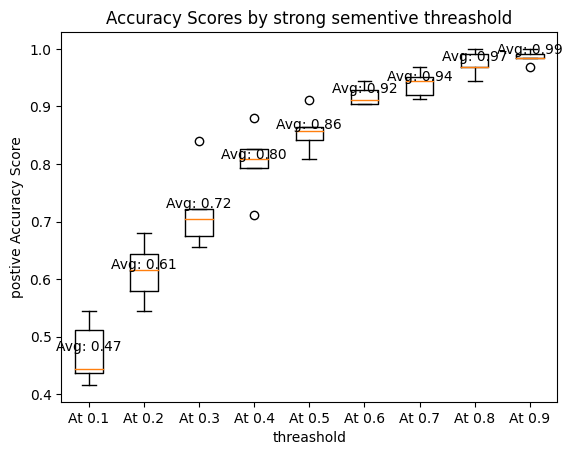

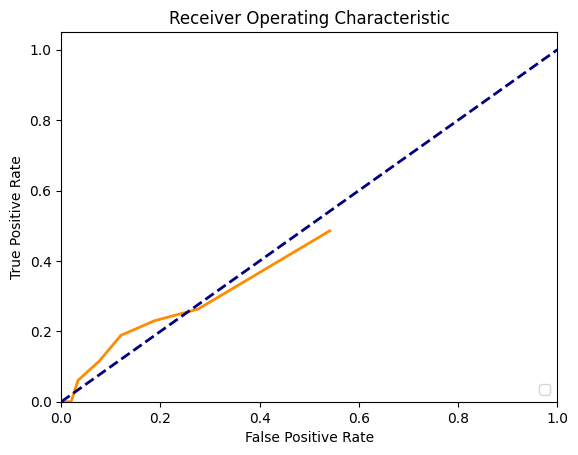

TP: 84 FP: 16 FN: 19 TN: 7
TP: 69 FP: 34 FN: 10 TN: 13
TP: 81 FP: 19 FN: 15 TN: 10
TP: 56 FP: 21 FN: 29 TN: 19
TP: 45 FP: 31 FN: 27 TN: 22
TP: 62 FP: 28 FN: 26 TN: 10
TP: 55 FP: 35 FN: 14 TN: 22
TP: 58 FP: 29 FN: 21 TN: 17
TP: 43 FP: 20 FN: 34 TN: 28
TP: 37 FP: 25 FN: 29 TN: 34
TP: 41 FP: 40 FN: 26 TN: 19
TP: 36 FP: 38 FN: 22 TN: 30
TP: 44 FP: 26 FN: 31 TN: 24
TP: 26 FP: 23 FN: 35 TN: 41
TP: 21 FP: 30 FN: 34 TN: 40
TP: 27 FP: 43 FN: 27 TN: 29
TP: 25 FP: 35 FN: 30 TN: 36
TP: 27 FP: 31 FN: 38 TN: 29
TP: 18 FP: 17 FN: 41 TN: 49
TP: 11 FP: 29 FN: 27 TN: 58
TP: 22 FP: 36 FN: 21 TN: 47
TP: 16 FP: 33 FN: 31 TN: 46
TP: 21 FP: 24 FN: 36 TN: 44
TP: 12 FP: 16 FN: 36 TN: 61
TP: 9 FP: 22 FN: 24 TN: 70
TP: 10 FP: 34 FN: 22 TN: 60
TP: 11 FP: 26 FN: 22 TN: 67
TP: 11 FP: 19 FN: 30 TN: 65
TP: 8 FP: 13 FN: 33 TN: 71
TP: 3 FP: 20 FN: 21 TN: 81
TP: 2 FP: 26 FN: 11 TN: 87
TP: 7 FP: 13 FN: 21 TN: 85
TP: 2 FP: 16 FN: 25 TN: 82
TP: 7 FP: 9 FN: 24 TN: 85
TP: 1 FP: 19 FN: 13 TN: 92
TP: 2 FP: 13 FN: 7 TN: 104
TP:

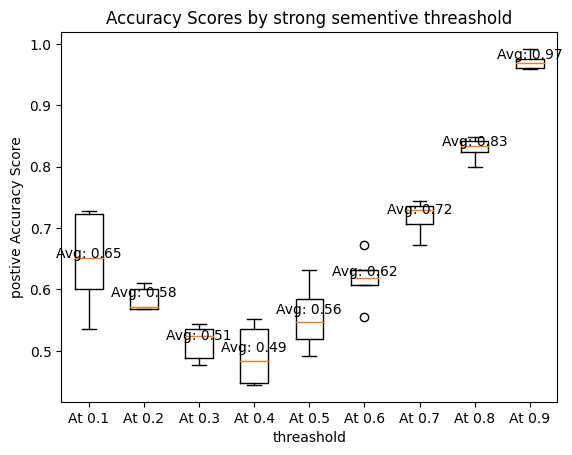

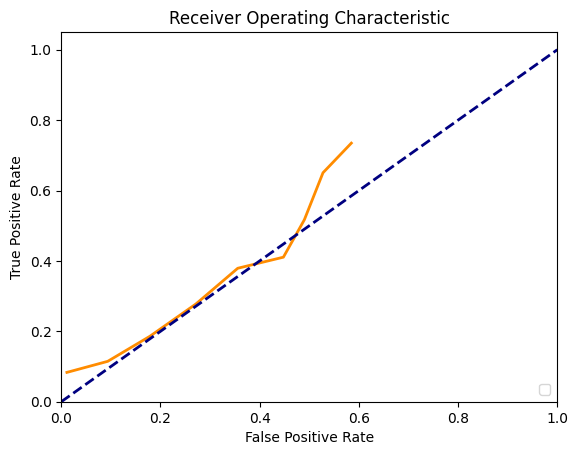

TP: 66 FP: 28 FN: 25 TN: 7
TP: 73 FP: 26 FN: 20 TN: 7
TP: 85 FP: 17 FN: 16 TN: 7
TP: 58 FP: 34 FN: 15 TN: 18
TP: 64 FP: 18 FN: 28 TN: 15
TP: 34 FP: 27 FN: 34 TN: 31
TP: 32 FP: 35 FN: 24 TN: 35
TP: 40 FP: 15 FN: 44 TN: 26
TP: 35 FP: 39 FN: 15 TN: 36
TP: 36 FP: 29 FN: 24 TN: 36
TP: 13 FP: 20 FN: 29 TN: 64
TP: 13 FP: 23 FN: 26 TN: 64
TP: 16 FP: 18 FN: 35 TN: 56
TP: 28 FP: 32 FN: 19 TN: 46
TP: 18 FP: 30 FN: 32 TN: 45
TP: 6 FP: 11 FN: 22 TN: 87
TP: 6 FP: 11 FN: 17 TN: 92
TP: 3 FP: 16 FN: 21 TN: 85
TP: 14 FP: 27 FN: 20 TN: 64
TP: 13 FP: 23 FN: 30 TN: 59
TP: 1 FP: 5 FN: 13 TN: 107
TP: 3 FP: 8 FN: 6 TN: 109
TP: 2 FP: 11 FN: 6 TN: 106
TP: 6 FP: 24 FN: 15 TN: 80
TP: 7 FP: 18 FN: 29 TN: 71
TP: 0 FP: 3 FN: 7 TN: 116
TP: 1 FP: 5 FN: 8 TN: 112
TP: 0 FP: 9 FN: 9 TN: 107
TP: 3 FP: 21 FN: 5 TN: 96
TP: 4 FP: 12 FN: 29 TN: 80
TP: 0 FP: 3 FN: 1 TN: 122
TP: 0 FP: 1 FN: 3 TN: 122
TP: 0 FP: 6 FN: 3 TN: 116
TP: 0 FP: 12 FN: 3 TN: 110
TP: 0 FP: 11 FN: 9 TN: 105
TP: 0 FP: 2 FN: 0 TN: 124
TP: 0 FP: 0 FN: 2 TN: 1

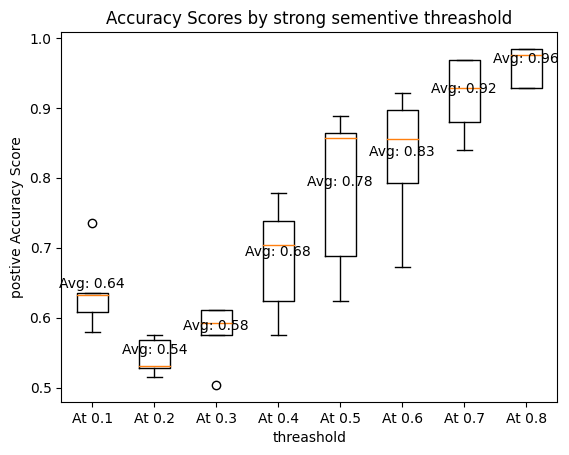

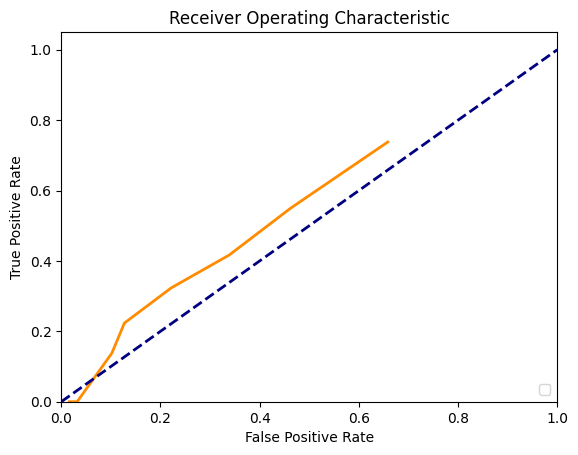

TP: 39 FP: 25 FN: 30 TN: 32
TP: 32 FP: 30 FN: 35 TN: 29
TP: 33 FP: 34 FN: 29 TN: 29
TP: 38 FP: 42 FN: 19 TN: 26
TP: 40 FP: 34 FN: 27 TN: 24
TP: 7 FP: 25 FN: 32 TN: 62
TP: 7 FP: 23 FN: 32 TN: 64
TP: 7 FP: 17 FN: 22 TN: 79
TP: 14 FP: 31 FN: 26 TN: 54
TP: 17 FP: 35 FN: 30 TN: 43
TP: 7 FP: 13 FN: 21 TN: 85
TP: 6 FP: 14 FN: 27 TN: 79
TP: 3 FP: 10 FN: 18 TN: 94
TP: 14 FP: 24 FN: 20 TN: 67
TP: 12 FP: 31 FN: 15 TN: 67
TP: 1 FP: 11 FN: 17 TN: 97
TP: 2 FP: 11 FN: 20 TN: 93
TP: 1 FP: 6 FN: 10 TN: 108
TP: 13 FP: 20 FN: 16 TN: 76
TP: 11 FP: 27 FN: 18 TN: 69
TP: 1 FP: 9 FN: 16 TN: 100
TP: 2 FP: 9 FN: 13 TN: 102
TP: 2 FP: 3 FN: 10 TN: 110
TP: 10 FP: 17 FN: 15 TN: 83
TP: 3 FP: 27 FN: 14 TN: 81
TP: 0 FP: 8 FN: 12 TN: 106
TP: 2 FP: 7 FN: 8 TN: 109
TP: 1 FP: 3 FN: 3 TN: 118
TP: 6 FP: 16 FN: 13 TN: 90
TP: 1 FP: 27 FN: 7 TN: 90
TP: 0 FP: 4 FN: 8 TN: 114
TP: 0 FP: 6 FN: 3 TN: 117
TP: 0 FP: 3 FN: 4 TN: 118
TP: 3 FP: 13 FN: 13 TN: 96
TP: 2 FP: 20 FN: 3 TN: 100
TP: 0 FP: 3 FN: 2 TN: 121
TP: 0 FP: 1 FN: 2 TN: 1

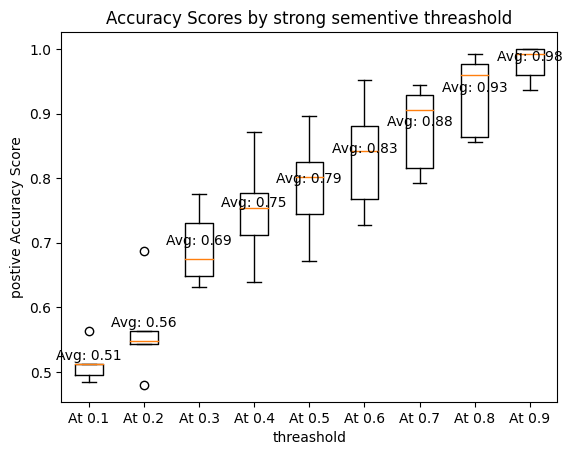

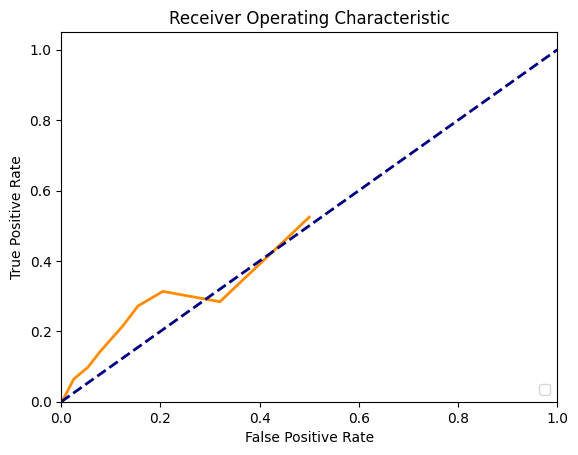

In [72]:
for i in scores_c.T:
  classification_strong_test(i)

In [73]:
labels

['anger', 'joy', 'optimism', 'sadness']

#### forth analysis - using the feedforward neural networks , for deep connection


In [74]:
# encode the labels:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels_part2)
numeric_categories = encoder.transform(labels_part2)
# Print the resulting numeric categories

In [75]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
sam = []
for i in range(0,5):

  # Define the model architecture
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(data_part2.shape[1],)),
      #tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dense(8, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Split the data into training and testing sets
  # train_data = data_part2[:140]
  # train_labels = labels_part2[:140]
  # test_data = data_part2[140:]
  # test_labels = labels_part2[140:]
  train_data, test_data, train_labels, test_labels = train_test_split(data_part2, numeric_categories, test_size=0.1)
  # Train the model
  model.fit(train_data, train_labels, epochs=3, batch_size=8)

  # Evaluate the model on the test set
  loss, accuracy = model.evaluate(test_data, test_labels)
  print('Test Loss:', loss)
  print('Test Accuracy:', accuracy)
  sam.append(accuracy)


Epoch 1/3
71/71 [==============================] - 10s 132ms/step - loss: 1.0278 - accuracy: 0.3883
Epoch 2/3
71/71 [==============================] - 9s 129ms/step - loss: -0.8262 - accuracy: 0.4468
Epoch 3/3
2/2 [==============================] - 0s 30ms/step - loss: -2.5067 - accuracy: 0.4921
Test Loss: -2.5067241191864014
Test Accuracy: 0.4920634925365448
Epoch 1/3
71/71 [==============================] - 11s 142ms/step - loss: 0.2783 - accuracy: 0.4521
Epoch 2/3
71/71 [==============================] - 9s 132ms/step - loss: -1.3241 - accuracy: 0.4521
Epoch 3/3
2/2 [==============================] - 0s 28ms/step - loss: -3.3057 - accuracy: 0.4444
Test Loss: -3.305722951889038
Test Accuracy: 0.4444444477558136
Epoch 1/3
71/71 [==============================] - 11s 140ms/step - loss: 0.5869 - accuracy: 0.4273
Epoch 2/3
71/71 [==============================] - 10s 141ms/step - loss: -1.1456 - accuracy: 0.4450
Epoch 3/3
2/2 [==============================] - 0s 35ms/step - loss: -3.332

In [76]:
print("the avarage accuracy is:" ,sum(sam)/ len(sam))

the avarage accuracy is: 0.4857142984867096
